In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.cElementTree as ET
import glob 
import os
import json
import random 
import shutil 

from PIL import Image, ImageOps

In [3]:
len(glob.glob('/kaggle/input/face-mask-detection/images/*'))

853

In [4]:
with open('/kaggle/input/face-mask-detection/annotations/maksssksksss10.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss10.png</filename>
    <size>
        <width>301</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>98</xmin>
            <ymin>267</ymin>
            <xmax>194</xmax>
            <ymax>383</ymax>
        </bndbox>
    </object>
</annotation>


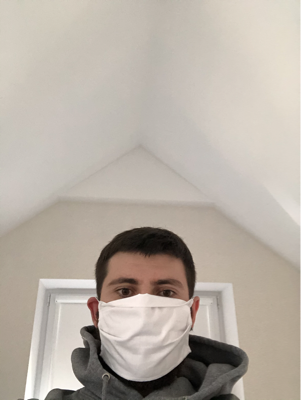

In [5]:
Image.open("/kaggle/input/face-mask-detection/images/maksssksksss10.png")

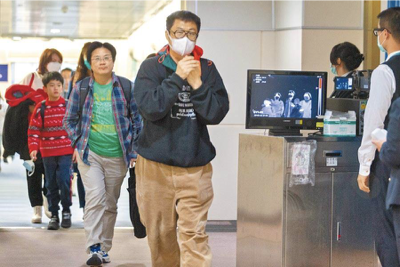

In [6]:
Image.open('/kaggle/input/face-mask-detection/images/maksssksksss179.png')

In [7]:
# –ü–µ—Ä–µ–≤–æ–¥ XML-—Ñ–æ—Ä–º–∞—Ç –≤ TXT-—Ñ–æ—Ä–º–∞—Ç
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0])/2)/w
    y_center = ((bbox[3] + bbox[1])/2)/h
    
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    
    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center, width, height
    w_half_len = (bbox[2] * w)/2
    h_half_len = (bbox[3] * h)/2
    
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    
    return [xmin, ymin, xmax, ymax]

classes = ["without_mask", "with_mask", "mask_weared_incorrect"] # –∫–ª–∞—Å—Å—ã

input_dir = "/kaggle/input/face-mask-detection/annotations"
output_dir = "/kaggle/working/labels"
image_dir = "/kaggle/input/face-mask-detection/images"

if not os.path.isdir(output_dir): # —Å–æ–∑–¥–∞–Ω–µ –ø–∞–ø–∫–∏ –¥–ª—è –≤—ã—Ö–æ–¥–∞
    os.mkdir(output_dir)
import glob 

files = glob.glob(os.path.join(input_dir, "*.xml")) # —Å–æ–µ–¥–∏–Ω–µ–Ω–∏–µ –≤ –ø—É—Ç—å, —Ö–æ—Ç—è –º–æ–∂–Ω–æ –ø—Ä–æ—Å—Ç–æ –±—ã–ª–æ –ø–∞–ø–∫—É —É–∫–∞–∑–∞—Ç—å
                                                    # –∏ —á–µ—Ä–µ–∑ –≤—Å–ø–∏—Å–∫–æ–≤—ã–µ –≤–∫–ª—é—á–µ–Ω–∏—è –∑–∞–≥–Ω–∞—Ç—å –≤ str
# –∞–Ω–∞–ª–æ–≥ glob.glob("/kaggle/input/face-mask-detection/annotations/*.xml")
for fil in files:
    basename = os.path.basename(fil) # –¥–æ—Å—Ç–∞–µ—Ç –∏–º—è —Ñ–∞–π–ª–∞ —Å —Ä–∞—Å—à–∏—Ä–µ–Ω–∏–µ–º
    # –∞–Ω–∞–ª–æ–≥ fil.split('/')[-1]
    filename = os.path.splitext(basename)[0] # —Ç–∏–ø–∞ –∫–æ—Ä—Ç–µ–∂–∞ –∏–∑ 2-—Ö —á–∞—Å—Ç–µ–π: ('–∏–º—è_—Ñ–∞–π–ª–∞', '.txt')
    # –∞–Ω–∞–ª–æ–≥ basename.split('.')[0]
    #---------------------------------------------------------------------
    # –±–ª–æ–∫ –ø—Ä–æ–≤–µ—Ä–∫–∏: —Ç–∏–ø–∞ –µ—Å–ª–∏ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç –∫–∞—Ä—Ç–∏–Ω–∫–∞ —Å —Ç–∞–∫–∏–º –∂–µ –Ω–∞–∑–≤–∞–Ω–∏–µ–º, —Ç–æ —Ä–∞–±–æ—Ç–∞–µ–º, –∏–Ω–∞—á–µ –ø—Ä–æ–ø—É—Å–∫–∞–µ–º
    # os.path.exists - –ø—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue 
    #---------------------------------------------------------------------
    result = []
    
    # –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ xml-—Ñ–∞–π–ª–∞
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)
    
    for obj in root.findall("object"): # —Ü–∏–∫–ª –∫–æ—Ç–æ—Ä—ã–π –∏—â–µ—Ç –≤—Å–µ –º–µ—Ç–∫–∏ —Å –∫–æ—Ä–æ–±–∫–∞–º–∏
        label = obj.find("name").text 
        
        # –ü—Ä–æ–≤–µ—Ä—è–µ—Ç –Ω–∞–ª–∏—á–∏–µ –Ω–æ–≤—ã—Ö –∫–ª–∞—Å—Å–æ–≤ –∏ –¥–æ–±–∞–≤–ª—è–µ—Ç –∏—Ö –≤ —Å–ø–∏—Å–æ–∫
        if label not in classes:
            classes.append(label)
        index = classes.index(label) # –≤—ã–≤–æ–¥–∏—Ç –∏–Ω–¥–µ–∫—Å –∫–ª–∞—Å—Å–∞ –≤ —Å–ø–∏—Å–∫–µ
        pil_bbox = [int(x.text) for x in obj.find("bndbox")] # —Ç–∏–ø–∞ –¥–æ—Å—Ç–∞–µ—Ç [28, 55, 46, 71]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height) # —Ç–∏–ø–∞ –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ—Ç –≤ (x_—Ü–µ–Ω—Ç—Ä, y_—Ü–µ–Ω—Ç—Ä, w, h)
        # —Ç–∞–∫ –≤—ã–≥–ª—è–¥–∏—Ç –≤—ã—Ö–æ–¥:
#         [0.0925, 0.27876106194690264, 0.045, 0.07079646017699115]
#         [0.26125, 0.30973451327433627, 0.0325, 0.07079646017699115]
#         [0.44, 0.30973451327433627, 0.085, 0.17699115044247787]
        
        # –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –≤ —Å—Ç—Ä–æ–∫—É
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        # —Ç–∞–∫ –≤—ã–≥–ª—è–¥–∏—Ç –≤—ã—Ö–æ–¥:
#         0.0925 0.27876106194690264 0.045 0.07079646017699115
#         0.26125 0.30973451327433627 0.0325 0.07079646017699115
#         0.44 0.30973451327433627 0.085 0.17699115044247787
#         print(bbox_string)
        result.append(f"{index} {bbox_string}")
        # –∫–æ—Ä–æ—á–µ –Ω–∞ –≤—ã—Ö–æ–¥–µ —Å–ø–∏—Å–æ–∫ —Å—Ç—Ä–æ–∫ —Å –º–µ—Ç–∫–∞–º–∏ –∏ –∫–æ—Ä–æ–±–∫–∞–º–∏ [x,y,w,h], —Ä–∞–∑–¥–µ–ª–µ–Ω–Ω—ã—Ö –ø—Ä–æ–±–µ–ª–∞–º–∏
        # –≤—ã–≤–æ–¥–∏—Ç—Å—è –¥–ª—è –∫–∞–¥–æ–π –∫–∞—Ä—Ç–∏–Ω–∫–∏
        # ['1 0.0925 0.27876106194690264 0.045 0.07079646017699115', 
        #  '1 0.26125 0.30973451327433627 0.0325 0.07079646017699115']

#---------------------------------------------------------------------------------------------------------
# —Å–æ–∑–¥–∞–µ–º —Ñ–∞–π–ª—ã txt –¥–ª—è –∫–∞–∂–¥–æ–π –∫–∞—Ä—Ç–∏–Ω–∫–∏ —Å –∫–ª–∞—Å—Å–∞–º–∏ –∏ –∫–æ—Ä–æ–±–∫–∞–º–∏ –∏ —Ñ–∞–π–ª txt c –∫–ª–∞—Å—Å–∞–º–∏
    if result: 
        # —Å–æ–∑–¥–∞–µ–º —Ñ–∞–π–ª—ã txt –¥–ª—è –∫–∞–∂–¥–æ–π –∫–∞—Ä—Ç–∏–Ω–∫–∏, –≤ –≤–∏–¥–µ (—Ñ–æ—Ä–º–∞—Ç–∞ yolo –¥–ª—è –∫–∞–∂–¥–æ–≥–æ xml-—Ñ–∞–π–ª–∞):
#         1 0.625 0.3651685393258427 0.08 0.13857677902621723
#         1 0.8825 0.3089887640449438 0.075 0.12359550561797752
#         1 0.335 0.40074906367041196 0.075 0.14232209737827714
#         1 0.39 0.41198501872659177 0.05 0.0898876404494382
#         1 0.22125 0.4044943820224719 0.0575 0.1198501872659176
#         1 0.04125 0.46629213483146065 0.0725 0.12359550561797752
        with open(os.path.join(output_dir, f"{filename}.txt"), # —Å–æ–∑–¥–∞–µ–º —Ç–µ–∫—Å—Ç–æ–≤—ã–π —Ñ–∞–π–ª
                 "w", encoding = 'utf-8') as f:
            f.write("\n".join(result)) # –∑–∞–ø–∏—Å—ã–≤–∞–µ–º –≤ —Ñ–∞–π–ª –¥–∞–Ω–Ω—ã–µ, –∫–∞–∂–¥—ã–π –≤ –Ω–æ–≤–æ–π —Å—Ç—Ä–æ–∫–µ
            #_____________________________
#             print(f)

# —Å–æ–∑–¥–∞–µ—Ç —Ñ–∞–π–ª txt —Å –∫–ª–∞—Å—Å–∞–º–∏, –∑–¥–µ—Å—å —Ñ–∞–π–ª —Å–æ —Å–ø–∏—Å–∫–æ–º: ["without_mask", "with_mask", "mask_weared_incorrect"]
with open("/kaggle/working/classes.txt", "w", encoding = 'utf-8') as f:
    f.write(json.dumps(classes)) # –∑–∞–ø–∏—Å—ã–≤–∞–µ—Ç —Ñ–∞–π–ª —Ç–∏–ø–∞ json

In [8]:
# # –¢–µ–∫—Å—Ç–æ–≤–∞—è –≤–µ—Ä—Å–∏—è –ø—Ä–∏–≤–µ–¥–µ–Ω–Ω–æ–π –≤—ã—à–µ –º–µ—Ç–∫–∏ –≤ —Ñ–æ—Ä–º–∞—Ç–µ XML
with open('/kaggle/working/labels/maksssksksss595.txt') as f:
    contents = f.read()
    print(contents)

1 0.13875 0.3258426966292135 0.0475 0.06741573033707865
1 0.315 0.3146067415730337 0.04 0.06741573033707865
1 0.4125 0.32209737827715357 0.04 0.0749063670411985
1 0.4575 0.2902621722846442 0.04 0.07116104868913857
1 0.62875 0.32397003745318353 0.0425 0.07116104868913857
1 0.75625 0.3295880149812734 0.0425 0.0749063670411985


# **Create Data For Yolov8**

In [9]:
# –ù–∞–∑–≤–∞–Ω–∏–µ –∏ —Å–æ–∑–¥–∞–Ω–∏–µ —Ñ–∞–π–ª–æ–≤, –ø–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–Ω—ã—Ö –¥–ª—è Yolov8
# –ó–î–ï–°–¨ –°–û–ó–î–ê–ï–ú –ù–ï–û–ë–•–û–î–ò–ú–´–ï –ü–ê–ü–ö–ò
if os.path.isfile('/kaggle/working/data'):
    print('There is  folder !')
else:
    os.mkdir('/kaggle/working/data')
os.mkdir('/kaggle/working/data/train')
os.mkdir('/kaggle/working/data/val')
os.mkdir('/kaggle/working/data/test')
os.mkdir('/kaggle/working/data/train/images')
os.mkdir('/kaggle/working/data/train/labels')
os.mkdir('/kaggle/working/data/test/images')
os.mkdir('/kaggle/working/data/test/labels')
os.mkdir('/kaggle/working/data/val/images')
os.mkdir('/kaggle/working/data/val/labels')

In [10]:
# –°–æ–∑–¥–∞–µ–º —Å–ø–∏—Å–æ–∫ –Ω–∞–∑–≤–∞–Ω–∏–π –∫–∞—Ä—Ç–∏–Ω–æ–∫ –±–µ–∑ —Ä–∞—Å—à–∏—Ä–µ–Ω–∏–π
metarial = []

for i in os.listdir('/kaggle/input/face-mask-detection/images'):
    srt = i[:-4]
    metarial.append(srt)

In [11]:
metarial[:3]

['maksssksksss810', 'maksssksksss848', 'maksssksksss145']

In [12]:
# –ö–æ—Ä–æ—á–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–∞—Ä—Ç–∏–Ω–∫–∏ –ø–æ –ø–∞–ø–∫–∞–º –∏ —Ñ–∞–π–ª—ã txt —Å –∞–Ω–Ω–æ—Ç–∞—Ü–∏—è–º–∏, –∫–æ—Ä–æ–±–∫–∏ –≤—Å—è–∫–∏–µ
# –¥–ª—è –ø–æ–¥–∞—á–∏ –≤ –µ–ª—É8.


def preparedata(main_txt_file, main_img_file, train_size, test_size, val_size):
    for i in range(0, train_size):
        source_txt = main_txt_file + "/" + metarial[i] + ".txt"
        source_img = main_img_file + "/" + metarial[i] + ".png"
        
        mstring = metarial[i]
        train_destination_txt = "/kaggle/working/data/train/labels" + "/" + metarial[i] + ".txt"
        train_destination_png = "/kaggle/working/data/train/images" + "/" + metarial[i] + ".png"
        
        shutil.copy(source_txt, train_destination_txt)
        shutil.copy(source_img, train_destination_png)
    
    for l in range(train_size, train_size + test_size):
        source_txt = main_txt_file + "/" + metarial[l] + ".txt"
        source_img = main_img_file + "/" + metarial[l] + ".png"
        
        mstring = metarial[l]
        test_destination_txt = "/kaggle/working/data/test/labels" + "/" + metarial[l] + ".txt"
        test_destination_png = "/kaggle/working/data/test/images" + "/" + metarial[l] + ".png"
        
        shutil.copy(source_txt, test_destination_txt)
        shutil.copy(source_txt, test_destination_png)
        
    
    for n in range(train_size + test_size, train_size + test_size + val_size):
        source_txt = main_txt_file + "/" + metarial[n] + ".txt"
        source_img = main_img_file + "/" + metarial[n] + ".png"
        
        mstring = metarial[n]
        val_destination_txt = "/kaggle/working/data/val/labels" + "/" + metarial[n] + ".txt"
        val_destination_png = "/kaggle/working/data/val/images" + "/" + metarial[n] + ".png"
        
        shutil.copy(source_txt, val_destination_txt)
        shutil.copy(source_img, val_destination_png)

In [13]:
preparedata("/kaggle/working/labels","/kaggle/input/face-mask-detection/images", 603, 150, 100)

In [14]:
# —Å–æ–∑–¥–∞–ª–∏ —á—Ç–æ-—Ç–æ —Ç–∏–ø–∞ —Ç–µ–∫—Å–∫–æ–≤–æ–≥–æ —Ñ–∞–π–ª–∞ —Å –¥–∞–Ω–Ω—ã–º–∏ yaml_text, –ø—Ä—è–º –∏ —Ñ–æ—Ä–º–∞ —Ç–∞–∫–∞—è-–∂–µ –∏ –±–æ–ª—å—à–µ –Ω–∏—á–µ–≥–æ
yaml_text = """train: /kaggle/working/data/train/images
val: /kaggle/working/data/val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]"""

with open("/kaggle/working/data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [15]:
%cat /kaggle/working/data/data.yaml # —Ç–∏–ø–∞ —á—Ç–æ-—Ç–æ —Ç–∏–ø–∞ —Å–æ–¥–µ—Ä–∂–∏–º–æ–≥–æ –ø–æ—Å–º–æ—Ç—Ä–µ–ª–∏ —à—Ç–æ–ª–∏ %cat —à—Ç–æ –∑–∞ —Ç–∞–∫–æ–µ, –≤ –∏–Ω–µ—Ç–µ –Ω–µ—Ç

train: /kaggle/working/data/train/images
val: /kaggle/working/data/val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]

# **–ì—Ä—É–∑–∏–º –º–æ–¥–µ–ª—å –µ–ª—É8**

In [16]:
# –º—ã —É—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º –±–∏–±–ª–∏–æ—Ç–µ–∫—É ultralytics, —á—Ç–æ–±—ã –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –±–∏–±–ª–∏–æ—Ç–µ–∫—É YoloV8
%pip install ultralytics

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41.3/41.3 kB 706.9 kB/s eta 0:00:0000:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 783.5/783.5 kB 6.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.36 üöÄ Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ‚úÖ (4 CPUs, 31.4 GB RAM, 5689.4/8062.4 GB disk)


# **–û–±—É—á–µ–Ω–∏–µ** —Ç–∏–ø–∞

In [18]:
# —Ç–∏–ø–∞ –ø–∞–ø–∫—É —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏ —Å–æ–∑–¥–∞–µ–º
if os.path.isfile('/kaggle/working/Result/'):
    print("There is result folder")
else:
    os.mkdir("/kaggle/working/Result/")

In [19]:
%cd /kaggle/working/Result/

/kaggle/working/Result


In [20]:
!yolo train model=yolov8n.pt data = /kaggle/working/data/data.yaml epochs = 50 imgsz = 640

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6.23M/6.23M [00:00<00:00, 76.7MB/s]
Ultralytics YOLOv8.2.36 üöÄ Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

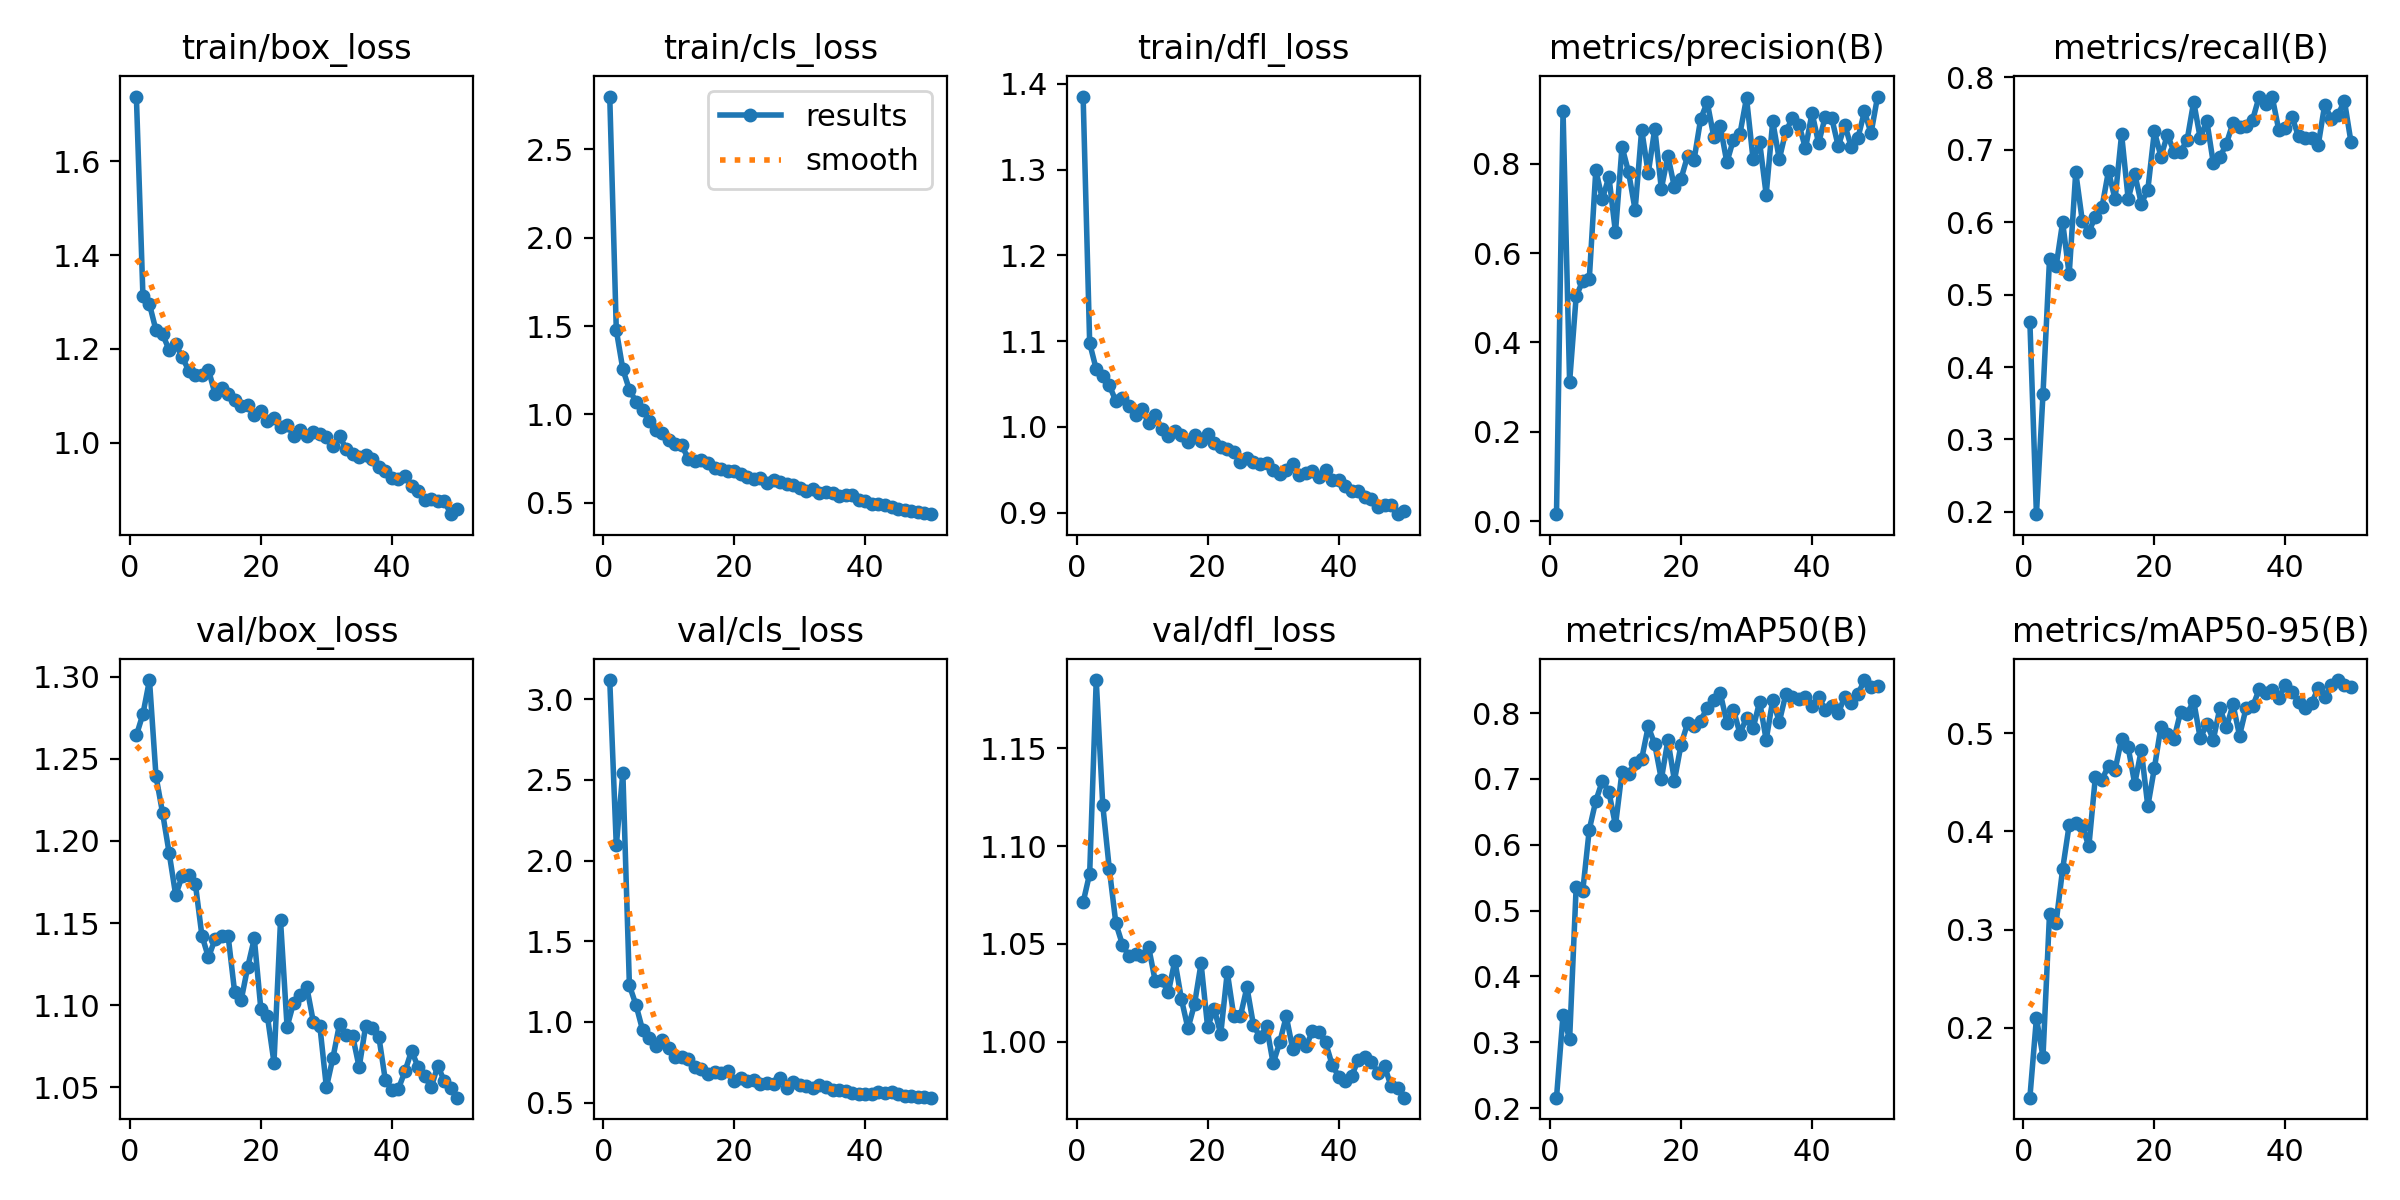

In [21]:
 Image.open("/kaggle/working/Result/runs/detect/train/results.png")

# **Detection**

In [22]:
# The detection process we performed on the test data set
!yolo predict model = /kaggle/working/Result/runs/detect/train/weights/best.pt  source='/kaggle/working/data/val/images'

Ultralytics YOLOv8.2.36 üöÄ Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs

image 1/100 /kaggle/working/data/val/images/maksssksksss101.png: 640x512 1 with_mask, 62.7ms
image 2/100 /kaggle/working/data/val/images/maksssksksss106.png: 448x640 (no detections), 57.7ms
image 3/100 /kaggle/working/data/val/images/maksssksksss109.png: 640x640 1 with_mask, 7.9ms
image 4/100 /kaggle/working/data/val/images/maksssksksss139.png: 384x640 1 without_mask, 17 with_masks, 1 mask_weared_incorrect, 75.9ms
image 5/100 /kaggle/working/data/val/images/maksssksksss14.png: 640x512 1 without_mask, 7.2ms
image 6/100 /kaggle/working/data/val/images/maksssksksss140.png: 448x640 2 with_masks, 6.9ms
image 7/100 /kaggle/working/data/val/images/maksssksksss141.png: 448x640 2 with_masks, 7.3ms
image 8/100 /kaggle/working/data/val/images/maksssksksss142.png: 480x640 1 with_mask, 58.0ms
image 9/100 /kaggle/working/data/val/images/m

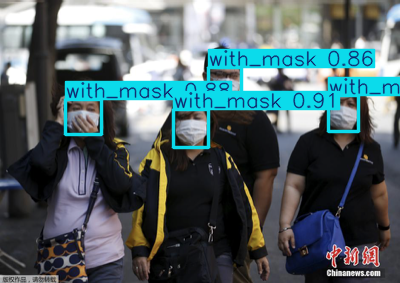

In [23]:
Image.open('/kaggle/working/Result/runs/detect/predict/maksssksksss450.png')

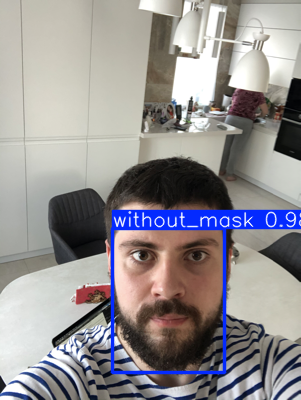

In [24]:
Image.open('/kaggle/working/Result/runs/detect/predict/maksssksksss455.png')